# Sprint 08. Entrena els models del teu projecte.

## Importar librerías 

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

## Leer el subconjunto de datos

In [262]:
data = pd.read_csv('bank_dataset.csv')
print(data.head()) # cargado correctamente
X = data.drop('deposit', axis=1)  # características
y = data['deposit'] # objetivo

    age         job  marital  education default  balance housing loan  \
0  59.0      admin.  married  secondary      no     2343     yes   no   
1  56.0      admin.  married  secondary      no       45      no   no   
2  41.0  technician  married  secondary      no     1270     yes   no   
3  55.0    services  married  secondary      no     2476     yes   no   
4  54.0      admin.  married   tertiary      no      184      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes  


In [263]:
data.info() 
data.describe()
# Hay 17 columnas, algunas numéricas y otras categóricas. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


,age,balance,day,duration,campaign,pdays,previous
count,11152.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.235384,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.914934,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


## Valores nulos

In [264]:
# Visualización de valores nulos
data.isnull().sum()

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [265]:
# Solucionar
for column in data.columns:
    if data[column].dtype in ['float64', 'int64']:  #columna numérica
        media = data[column].mean()  #media
        data[column] = data[column].fillna(media)  #reemplazar
    else:  #categórica
        moda = data[column].mode().iloc[0]  #moda
        data[column] = data[column].fillna(moda)  #reemplazar
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [266]:
# OJO!!! Que aunque no lo parezca, pdays y previous también tienen valores nulos
# Son valores numéricos, pero pdays es principalmente '-1', que indica que no hubo contacto previo. Sin embargo, también contiene valore spositivos que reflejan el número de días desde el último contacto.
# PDAYS puede ser considerada variable numérica, pero el '-1' debe ser considerado como un valor nulo.
# Lo mismo sucede con previous.
# No podemos eliminarlos porque son la mayoría.

# Reemplazar los valores -1 por NaN para identificarlos como nulos
data['pdays'] = data['pdays'].replace(-1, np.nan)
data['previous'] = data['previous'].replace(-1, np.nan)
print("Negativos para pdays:")
print(data['pdays'].isnull().sum())  # Ver cuántos valores nulos hay en 'pdays'
print("De un total de filas:")
print(data['pdays'].shape[0])  # Ver cuántos valores nulos hay en 'pdays'

print("\nNegativos para previous:")
print(data['previous'].isnull().sum())  # Ver cuántos valores nulos hay en 'pdays'
print("De un total de filas:")
print(data['previous'].shape[0])  # Ver cuántos valores nulos hay en 'pdays'

Negativos para pdays:
8324
De un total de filas:
11162

Negativos para previous:
0
De un total de filas:
11162


In [267]:
pdays_mode = data['pdays'].mode()[0]  # Calcula la moda
data['pdays'] = data['pdays'].fillna(pdays_mode)

print("Negativos para pdays:")
print(data['pdays'].isnull().sum())  # Ver cuántos valores nulos hay en 'pdays'

Negativos para pdays:
0


## División del dataset

In [268]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
train, test = train_test_split(data, test_size=0.2, random_state=22)
print("Tamaño del conjunto de entrenamiento (train):", train.shape)
print("Tamaño del conjunto de prueba (test):", test.shape)
# Guardar los conjuntos en archivos CSV
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

# Chequear las primeras filas de ambos conjuntos
train.head()

Tamaño del conjunto de entrenamiento (train): (8929, 17)
Tamaño del conjunto de prueba (test): (2233, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
843,44.0,technician,married,secondary,no,267,no,no,cellular,22,aug,520,2,92.0,0,unknown,yes
1899,47.0,admin.,married,secondary,no,663,yes,yes,cellular,12,may,409,1,274.0,6,other,yes
7459,56.0,retired,married,tertiary,no,5769,no,no,unknown,20,jun,15,3,92.0,0,unknown,no
2346,54.0,management,married,tertiary,no,1464,no,no,cellular,30,jun,157,1,92.0,0,unknown,yes
5673,40.0,admin.,single,unknown,no,355,yes,no,cellular,7,apr,345,2,138.0,6,other,no


In [269]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
1904,37.0,admin.,single,primary,no,912,yes,no,cellular,12,may,637,3,328.0,22,other,yes
3113,52.0,services,married,secondary,no,659,no,no,cellular,28,jan,390,4,93.0,1,success,yes
1281,71.0,retired,married,tertiary,no,653,no,no,telephone,26,feb,367,1,92.0,0,unknown,yes
7856,29.0,blue-collar,married,primary,no,59,yes,yes,cellular,29,jul,665,4,92.0,0,unknown,no
6757,28.0,blue-collar,married,primary,no,278,yes,yes,telephone,15,may,31,9,373.0,4,other,no


## Codificar variables categóricas
1. Ordinales: tienen un orden narutal (una jerarquía) --> Usamos label encoding
2. Nominales: no tienen orden natural y no se interpretan como valores numéricos --> Usamos one hot encoding
3. Booleanas: son de 'sí' o 'no' --> Usamos label encoding

In [342]:
# Categóricas ordinales
label_encoder = LabelEncoder()
education_encoded = label_encoder.fit_transform(train['education'])
print(education_encoded)

[1 1 2 ... 1 1 0]


In [ ]:
# Encode

encoder = OneHotEncoder(sparse_output=False)  # Usar sparse_output=False para obtener una matriz densa
job_encoded = encoder.fit_transform(test[['job']])
job_encoded_df = pd.DataFrame(job_encoded, columns=encoder.get_feature_names_out(['job']))
marital_encoded = encoder.fit_transform(test[['marital']])
marital_encoded_df = pd.DataFrame(marital_encoded, columns=encoder.get_feature_names_out(['marital']))
contact_encoded = encoder.fit_transform(test[['contact']])
contact_encoded_df = pd.DataFrame(contact_encoded, columns=encoder.get_feature_names_out(['contact']))
month_encoded = encoder.fit_transform(test[['month']])
month_encoded_df = pd.DataFrame(month_encoded, columns=encoder.get_feature_names_out(['month']))
poutcome_encoded = encoder.fit_transform(test[['poutcome']])
poutcome_encoded_df = pd.DataFrame(poutcome_encoded, columns=encoder.get_feature_names_out(['poutcome']))

default_encoded = test['default'].map({'yes': 1, 'no': 0})
housing_encoded = test['housing'].map({'yes': 1, 'no': 0})
loan_encoded = test['loan'].map({'yes': 1, 'no': 0})
deposit_encoded = test['deposit'].map({'yes': 1, 'no': 0})

df_bool = pd.concat([default_encoded, housing_encoded, loan_encoded, deposit_encoded], axis=1)
df_nominal = pd.concat([job_encoded_df, marital_encoded_df, contact_encoded_df, month_encoded_df, poutcome_encoded_df], axis=1)

if isinstance(education_encoded, (list, np.ndarray)):
    education_encoded = pd.DataFrame(education_encoded, columns=['education_encoded'])
df_ordinal = pd.concat([education_encoded], axis = 1)

numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_numeric = test[numeric_columns] 

# Combinar todos los DataFrames
df_final = pd.concat([df_bool, df_nominal, df_ordinal, df_numeric], axis=1)

# Exportar a un archivo CSV
df_final.to_csv("output_test.csv", index=False)

In [343]:
# Categóricas nominales
encoder = OneHotEncoder(sparse_output=False)  # Usar sparse_output=False para obtener una matriz densa
job_encoded = encoder.fit_transform(train[['job']])
job_encoded_df = pd.DataFrame(job_encoded, columns=encoder.get_feature_names_out(['job']))
marital_encoded = encoder.fit_transform(train[['marital']])
marital_encoded_df = pd.DataFrame(marital_encoded, columns=encoder.get_feature_names_out(['marital']))
contact_encoded = encoder.fit_transform(train[['contact']])
contact_encoded_df = pd.DataFrame(contact_encoded, columns=encoder.get_feature_names_out(['contact']))
month_encoded = encoder.fit_transform(train[['month']])
month_encoded_df = pd.DataFrame(month_encoded, columns=encoder.get_feature_names_out(['month']))
poutcome_encoded = encoder.fit_transform(train[['poutcome']])
poutcome_encoded_df = pd.DataFrame(poutcome_encoded, columns=encoder.get_feature_names_out(['poutcome']))

# Printamos un ejemplo: job
print("poutcome_encoded by OneHotEncoder: ")
# 1 for unknown
print(poutcome_encoded_df)

poutcome_encoded by OneHotEncoder: 
      poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown
0                  0.0             0.0               0.0               1.0
1                  0.0             1.0               0.0               0.0
2                  0.0             0.0               0.0               1.0
3                  0.0             0.0               0.0               1.0
4                  0.0             1.0               0.0               0.0
...                ...             ...               ...               ...
8924               0.0             0.0               0.0               1.0
8925               0.0             0.0               0.0               1.0
8926               0.0             0.0               0.0               1.0
8927               0.0             0.0               0.0               1.0
8928               0.0             1.0               0.0               0.0

[8929 rows x 4 columns]


In [344]:
# Categóricas booleanas
default_encoded = train['default'].map({'yes': 1, 'no': 0})
housing_encoded = train['housing'].map({'yes': 1, 'no': 0})
loan_encoded = train['loan'].map({'yes': 1, 'no': 0})
deposit_encoded = train['deposit'].map({'yes': 1, 'no': 0})

count_yes = default_encoded.sum()
print("Cantidad de 'yes' en default_encoded:", count_yes)
print(default_encoded)

Cantidad de 'yes' en default_encoded: 135
843      0
1899     0
7459     0
2346     0
5673     0
        ..
6646     0
5478     0
8548     0
6276     0
11125    0
Name: default, Length: 8929, dtype: int64


In [351]:
df_bool = pd.concat([default_encoded, housing_encoded, loan_encoded, deposit_encoded], axis=1)
df_nominal = pd.concat([job_encoded_df, marital_encoded_df, contact_encoded_df, month_encoded_df, poutcome_encoded_df], axis=1)

if isinstance(education_encoded, (list, np.ndarray)):
    education_encoded = pd.DataFrame(education_encoded, columns=['education_encoded'])
df_ordinal = pd.concat([education_encoded], axis = 1)

numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_numeric = train[numeric_columns] 

# Índices están alineados
df_bool = df_bool.reset_index(drop=True)
df_nominal = df_nominal.reset_index(drop=True)
df_ordinal = df_ordinal.reset_index(drop=True)
df_numeric = df_numeric.reset_index(drop=True)

# Combinar todos los DataFrames
df_final = pd.concat([df_bool, df_nominal, df_ordinal, df_numeric], axis=1)

df_final.dropna(inplace=True)

# Exportar a un archivo CSV
df_final.to_csv("output_train.csv", index=False)

print("Archivo CSV creado con éxito: output_train.csv")

Archivo CSV creado con éxito: output_train.csv


## Detección de outliers

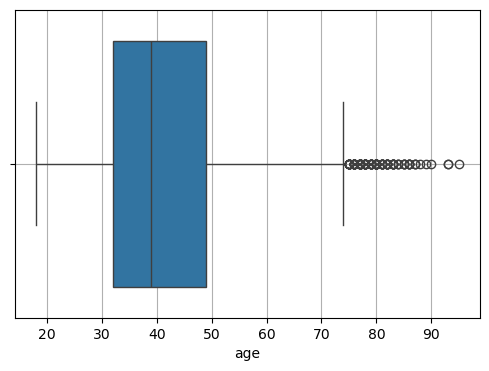

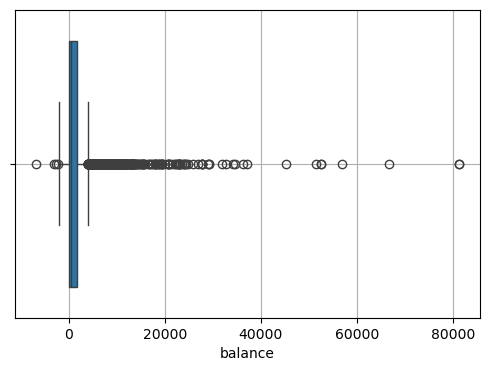

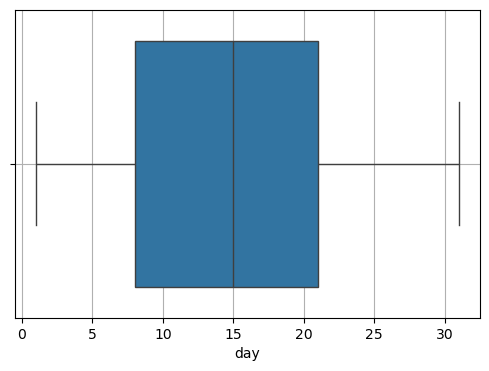

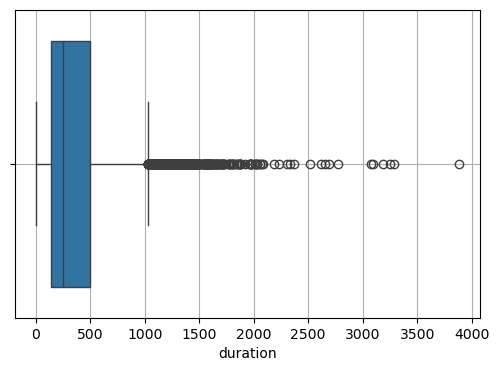

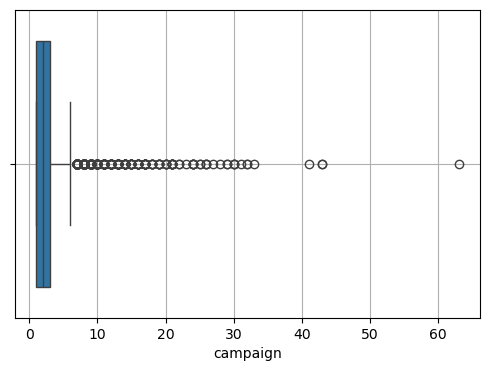

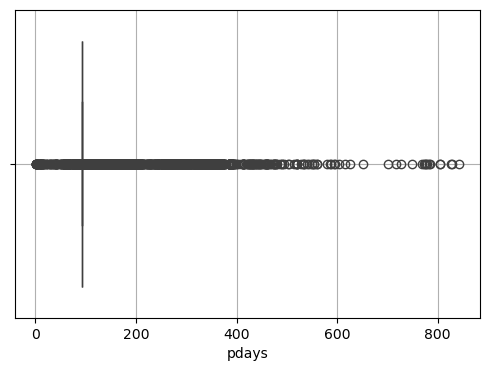

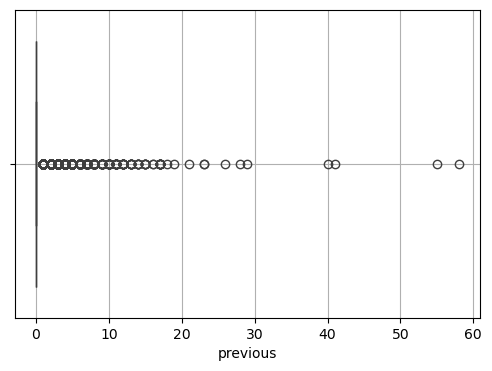

In [358]:
# Se deben detectar outliers antes de estandarizar o normalizar los datos, ya que el escalado afecta los valores y puede hacer que sea más difícil interpretar qué es un outlier en el contexto original de los datos
# Crear diagramas de caja para visualizar outliers en cada columna
# Abrir nuevo archivo
train_encoded = pd.read_csv('output_train.csv')
# Selección
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_encoded[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # Se detectaron outliers

In [359]:
# Para tratar los outliers se aplicará la técnica de Winsorización para mantener la estructura del dataset
# Función para calcular límites IQR
def calculate_iqr_limits(df, columns):
    limits_dict = {}
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        limits_dict[column] = (lower_bound, upper_bound)
        
    return limits_dict

In [360]:
# Función para winsorizar datos
def winsorize_data(df, columns):
    limits_dict = calculate_iqr_limits(df, columns)
    
    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsorizar: Reemplazar valores menores que el límite inferior y mayores que el límite superior
        df[column] = np.clip(df[column], lower_bound, upper_bound)
        
    return df

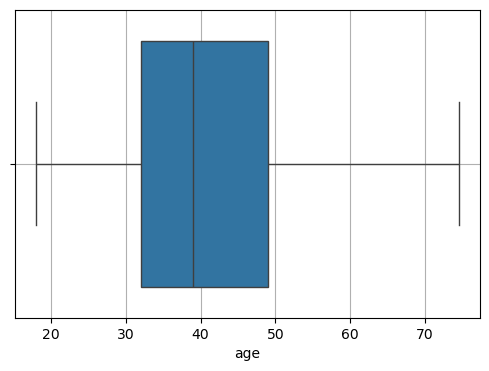

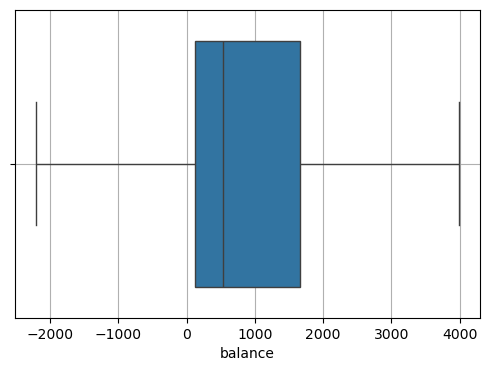

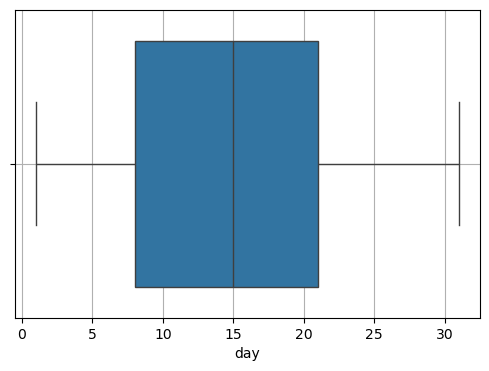

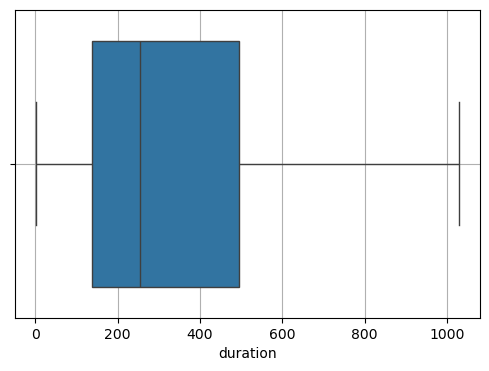

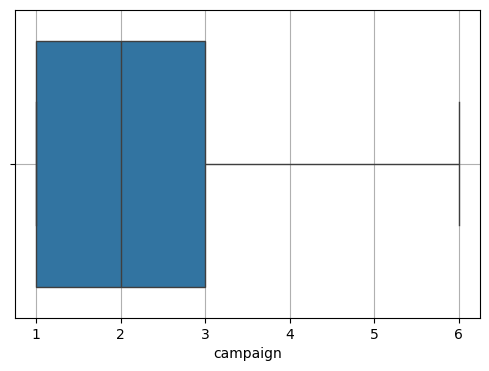

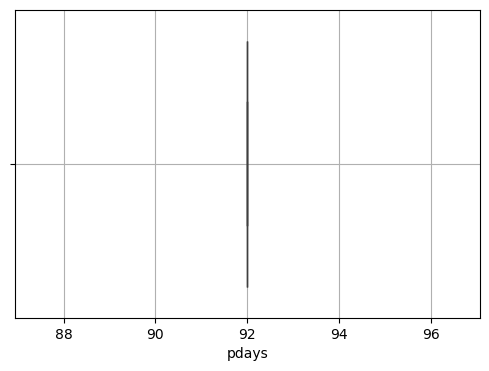

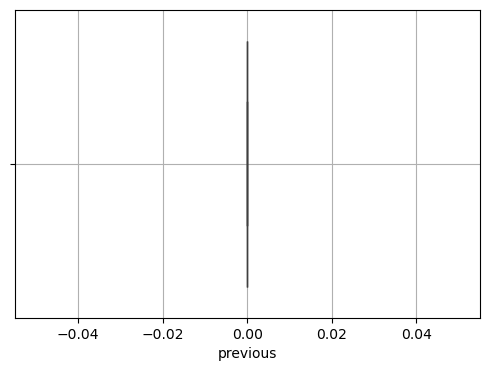

In [361]:
# Winsonarización
train_winsorized = winsorize_data(train_encoded, numeric_columns)

# Guardar el DataFrame en un archivo CSV
train_winsorized.to_csv('train_winsonarized.csv', index=False)
# Check
train_winsonarized = pd.read_csv('train_winsonarized.csv')
for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_winsonarized[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No se detectan outliers

## Selección de características relevantes aplicando el método de filtro


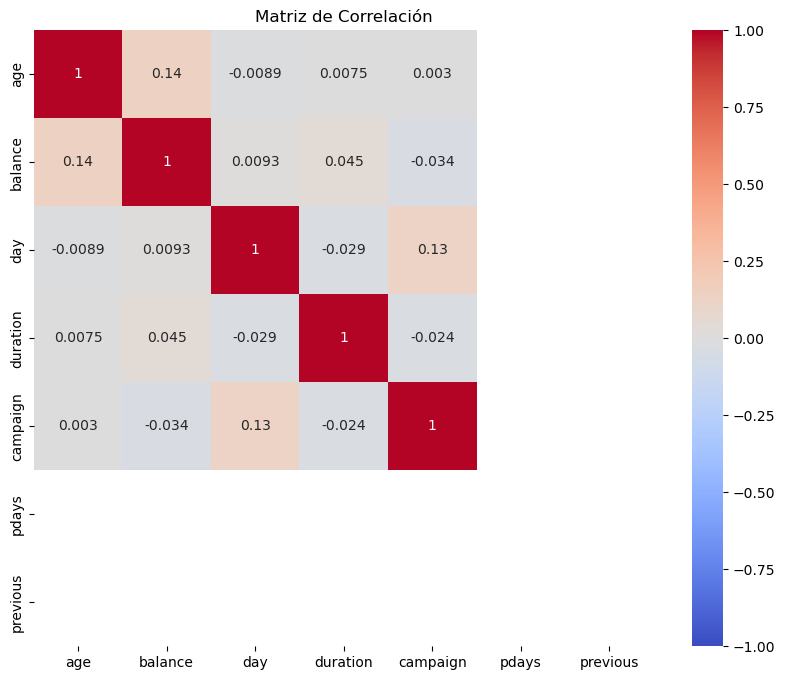

In [362]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
numeric_data = train_winsorized[numeric_columns]
correlation = numeric_data.corr()

# Visualitzar la matriu de correlació amb un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

No hay una relación positiva ni negativa fuerte entre variables numéricas.

## Estandarización de varibales numéricas

In [363]:
# Selección
train_wins = pd.read_csv('train_winsonarized.csv')
# Aplicar la estandarización solo a las columnas numéricas
train_wins[numeric_columns] = scaler.transform(train_wins[numeric_columns])

# Guardar el DataFrame estandarizado en el mismo archivo CSV
train_wins.to_csv('train_ready.csv', index=False)
# Verificar estandarización. Recordar que no se estandariza la variable objetivo
train_wins.head()

,default,housing,loan,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,poutcome_success,poutcome_unknown,education_encoded,age,balance,day,duration,campaign,pdays,previous
0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1,0.249533,-0.623648,0.765283,0.594467,-0.160524,0.0,0.0
1,0,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0.507020,-0.322553,-0.426667,0.202624,-0.817707,0.0,0.0
2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2,1.279479,2.202926,0.526893,-1.188243,0.496659,0.0,0.0
3,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2,1.107821,0.286482,1.718842,-0.686966,-0.817707,0.0,0.0
4,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3,-0.093782,-0.556738,-1.022642,-0.023304,-0.160524,0.0,0.0


In [364]:
# Verificar estandarización. Recordar que no se estandariza la variable objetivo porque queremos mantener la interpretación en su escala original.
scaled_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,8.929000e+03,8.929000e+03,8.929000e+03,8.929000e+03,8.929000e+03,8929.0,8929.0
mean,2.817025e-16,2.586251e-17,-7.917908e-17,5.232186e-17,-5.252080e-17,0.0,0.0
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.0,0.0
min,-1.982016e+00,-2.502075e+00,-1.737811e+00,-1.234135e+00,-8.177067e-01,0.0,0.0
25%,-7.804124e-01,-7.376997e-01,-9.034467e-01,-7.540385e-01,-8.177067e-01,0.0,0.0
50%,-1.796107e-01,-4.175955e-01,-6.908208e-02,-3.445446e-01,-1.605237e-01,0.0,0.0
75%,6.786773e-01,4.385504e-01,6.460876e-01,5.026840e-01,4.966593e-01,0.0,0.0
max,2.867312e+00,2.202926e+00,1.838037e+00,2.387768e+00,2.468208e+00,0.0,0.0


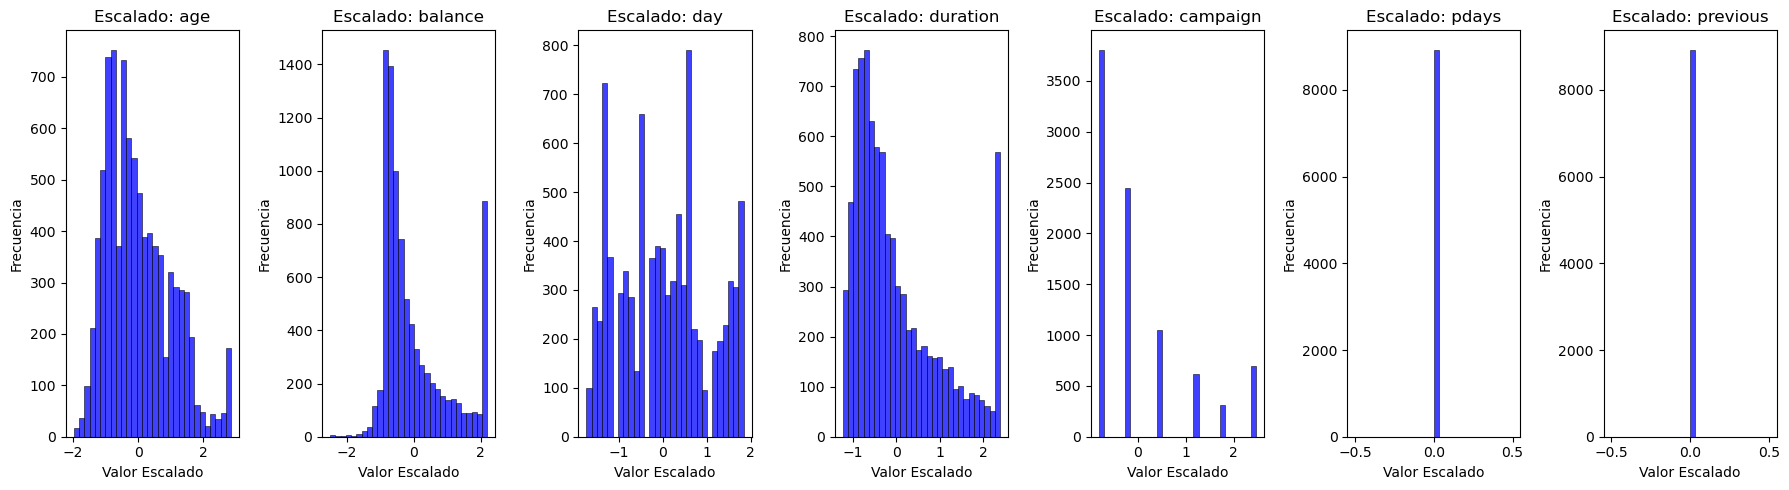

In [365]:
#Chequear el resultado con histogramas para ver media 0 y desvío estándar=1
# Crear una figura con subgráficos para cada columna numérica
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(18, 5))
# Iterar sobre cada columna para crear un histograma
for i, column in enumerate(numeric_columns):
    sns.histplot(scaled_df[column], kde=False, ax=axes[i], color='blue', bins=30)
    axes[i].set_title(f'Escalado: {column}')
    axes[i].set_xlabel('Valor Escalado')
    axes[i].set_ylabel('Frecuencia')
# Ajustar el diseño
plt.tight_layout()
plt.show()

## APLICAR TODAS LAS TRANSFORMACIONES AL CONJUNTO DE PRUEBA

In [329]:
# Leer el conjunto de prueba desde el archivo CSV
test = pd.read_csv('test_data.csv')

# Encode
label_encoder = LabelEncoder()
education_encoded = label_encoder.fit_transform(test['education'])

encoder = OneHotEncoder(sparse_output=False)  # Usar sparse_output=False para obtener una matriz densa
job_encoded = encoder.fit_transform(test[['job']])
job_encoded_df = pd.DataFrame(job_encoded, columns=encoder.get_feature_names_out(['job']))
marital_encoded = encoder.fit_transform(test[['marital']])
marital_encoded_df = pd.DataFrame(marital_encoded, columns=encoder.get_feature_names_out(['marital']))
contact_encoded = encoder.fit_transform(test[['contact']])
contact_encoded_df = pd.DataFrame(contact_encoded, columns=encoder.get_feature_names_out(['contact']))
month_encoded = encoder.fit_transform(test[['month']])
month_encoded_df = pd.DataFrame(month_encoded, columns=encoder.get_feature_names_out(['month']))
poutcome_encoded = encoder.fit_transform(test[['poutcome']])
poutcome_encoded_df = pd.DataFrame(poutcome_encoded, columns=encoder.get_feature_names_out(['poutcome']))

default_encoded = test['default'].map({'yes': 1, 'no': 0})
housing_encoded = test['housing'].map({'yes': 1, 'no': 0})
loan_encoded = test['loan'].map({'yes': 1, 'no': 0})
deposit_encoded = test['deposit'].map({'yes': 1, 'no': 0})

df_bool = pd.concat([default_encoded, housing_encoded, loan_encoded, deposit_encoded], axis=1)
df_nominal = pd.concat([job_encoded_df, marital_encoded_df, contact_encoded_df, month_encoded_df, poutcome_encoded_df], axis=1)

if isinstance(education_encoded, (list, np.ndarray)):
    education_encoded = pd.DataFrame(education_encoded, columns=['education_encoded'])
df_ordinal = pd.concat([education_encoded], axis = 1)

numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_numeric = test[numeric_columns] 

# Combinar todos los DataFrames
df_final = pd.concat([df_bool, df_nominal, df_ordinal, df_numeric], axis=1)

# Exportar a un archivo CSV
df_final.to_csv("output_test.csv", index=False)

print("Archivo CSV creado con éxito: output_test.csv")


Archivo CSV creado con éxito: output_test.csv


In [330]:
test_encoded = pd.read_csv('output_test.csv')

# Aplicar winsorización a las columnas especificadas
test_winsorized = winsorize_data(test_encoded, numeric_columns)

# Guardar el DataFrame en un archivo CSV
test_winsorized.to_csv('test_winsorized.csv', index=False)

# Estandarización
test2 = pd.read_csv('test_winsorized.csv')
# Aplicar la estandarización solo a las columnas numéricas
test2[numeric_columns] = scaler.transform(test2[numeric_columns])

# Guardar el DataFrame estandarizado en el mismo archivo CSV
test2.to_csv('test_ready.csv', index=False)

# Verificar estandarización. Recordar que no se estandariza la variable objetivo
test2.head()

,default,housing,loan,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,poutcome_success,poutcome_unknown,education_encoded,age,balance,day,duration,campaign,pdays,previous
0,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,-0.351268,-0.133227,-0.426667,1.007491,0.496659,0.0,2.5
1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1,0.936164,-0.325594,1.480452,0.135552,1.153842,0.0,1.0
2,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2,2.566911,-0.330156,1.242062,0.054359,-0.817707,0.0,0.0
3,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0,-1.037899,-0.781800,1.599647,1.106334,1.153842,0.0,0.0
4,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,-1.123728,-0.615285,-0.069082,-1.131761,2.468208,0.0,2.5


## Entrenar el modelo

In [366]:
# Validación cruzada para hacer varias pruebas
training = pd.read_csv('train_ready.csv')
testing = pd.read_csv('test_ready.csv')

In [368]:
# Especificar las columnas para características y variable objetivo
feature_columns = training.drop('deposit', axis=1)  # características
target_column = 'deposit'

# Separar características (X) y variable objetivo (y) en el conjunto de entrenamiento
X_train = training.drop('deposit', axis=1)  # características
y_train = training['deposit']

# Separar características (X) y variable objetivo (y) en el conjunto de prueba
X_test = testing.drop('deposit', axis=1)  # obj
y_test = testing['deposit']

# Crear el modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Ajustar el modelo con los datos de entrenamiento
# error aquí
rf_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del Modelo:")
print(accuracy_score(y_test, y_pred))

# Importancia de las características
feature_importances = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': rf_classifier.feature_importances_}
).sort_values(by='Importance', ascending=False)

print("\nImportancia de las características:")
print(feature_importances)
# Las métricas sugieren que el modelo funciona bien. Vamos a ajustarlo con el conjunto de entrenamiento completo.

Matriz de Confusión:
[[944 218]
 [117 954]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1162
           1       0.81      0.89      0.85      1071

    accuracy                           0.85      2233
   macro avg       0.85      0.85      0.85      2233
weighted avg       0.85      0.85      0.85      2233


Precisión del Modelo:
0.8499776085982983

Importancia de las características:
              Feature  Importance
41           duration    0.334615
39            balance    0.080796
38                age    0.080261
40                day    0.070618
35   poutcome_success    0.043934
42           campaign    0.034669
20    contact_unknown    0.026069
36   poutcome_unknown    0.024750
1             housing    0.024681
37  education_encoded    0.022873
18   contact_cellular    0.019294
29          month_may    0.014089
21          month_apr    0.012379
31          month_oct    0.011947
28          m

La **matriz de confusión** es una tabla que muestra el rendimiento del modelo clasificando ejemplos positivos (clase 1) y negativos (clase 0).
- 44 (TP - Verdaderos Positivos): Casos correctamente clasificados como clase 0.
- 218 (FP - Falsos Positivos): Casos de clase 0 incorrectamente clasificados como clase 1.
- 117 (FN - Falsos Negativos): Casos de clase 1 incorrectamente clasificados como clase 0.
- 954 (TN - Verdaderos Negativos): Casos correctamente clasificados como clase 1.

Esto indica que el modelo tiene buen desempeño general para verdaderos negativos, pero todavía comete errores en ambas clases.


El **informe de clasificación** incluye métricas clave para cada clase (0 y 1).
Clase 0:
- Precision: De todos los ejemplos que el modelo predijo como clase 0, el 89% realmente eran clase 0.
- Recall: De todos los ejemplos reales de clase 0, el modelo identificó correctamente el 81%.
- F1-Score: Media armónica entre precisión y recall, que penaliza más los desequilibrios entre ellas. Es 0.85 para la clase 0.

Clase 1:
- Precision: De todos los ejemplos que el modelo predijo como clase 1, el 81% realmente eran clase 1.
- Recall: De todos los ejemplos reales de clase 1, el modelo identificó correctamente el 89%.
- F1-Score: También es 0.85, lo que refleja un balance similar entre precisión y recall para la clase 1.

Promedios:
- Accuracy: El modelo clasifica correctamente el 85% de los ejemplos totales.
- Macro avg: promedio de 85%
- Weighted avg: promedio de 85%

Precisión del modelo: El valor 0.8499776 coincide con la precisión global del modelo, que es la proporción de predicciones correctas.

## Summary
- El modelo tiene precisión y recall balanceados (0.85).
- El modelo funciona bien para ambas clases, aunque tiene un ligero sesgo a favor de la clase 1.
- A mejorar: puede reducir los falsos positivos (FP = 218) y falsos negativos (FN = 117), lo que implica ajustar el umbral de clasificación o explorar técnicas adicionales